In [1]:
%reset -f
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0,'..')
from wavhandler import *
import numpy as np
import sys
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils_train import train_test_val_split, TrainConfiguration, train_generator, valid_generator,mosquito_data_split, train_model_dl
from utils_train import n_cpus
import matplotlib.pyplot as plt
import seaborn as sns
import os
seed = 42
np.random.seed(seed=seed)

In [2]:
splitting = 'random'
cust = 'na'
data_setting = 'raw'
model_setting = 'tsc_fcn_baseline'
layer_name = 'dense'#'global_average_pooling1d'

data = Dataset('Wingbeats')
print(data.target_classes)

print(f'SPLITTING DATA {splitting}')
X_train, X_val, X_test, y_train, y_val, y_test = mosquito_data_split(splitting=splitting, dataset=data)
if splitting == 'custom':
    X_train = X_train[cust]
    X_val = X_val[cust]
    y_train = y_train[cust]
    y_val = y_val[cust]

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
SPLITTING DATA random
Species: Ae. aegypti.
Read 85553 filenames in 1.50 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 1.49 seconds.
Species: An. arabiensis.
Read 19297 filenames in 1.48 seconds.
Species: An. gambiae.
Read 49471 filenames in 1.48 seconds.
Species: C. pipiens.
Read 30415 filenames in 1.50 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 1.47 seconds.


In [3]:
from utils_train import ModelConfiguration, TrainConfiguration

traincf = TrainConfiguration(dataset=data, 
                             setting=data_setting,
                             batch_size=64,
                             model_name=f'{splitting}_{data_setting}_{model_setting}_ss')
config = ModelConfiguration(model_setting=model_setting, 
                            data_setting=data_setting, 
                            target_names=traincf.target_names)
model = config.config

############ INPUT SHAPE:(5000, 1, 1)


In [4]:
# model.get_layer(layer_name)
layer_name = model.layers[-1].name

model.load_weights(f'../temp_data/results/dl/{splitting}_{data_setting}_{model_setting}_{cust}.h5')

In [5]:
from tensorflow.keras.models import Model


model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [6]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

In [7]:
# from utils_train import calculate_train_statistics
# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

# features = model.predict_generator(valid_generator(X_test, y_test, 
#                                                   batch_size=traincf.batch_size, 
#                                                   setting=traincf.setting, 
#                                                   target_names=traincf.target_names,
#                                                   preprocessing_train_stats=train_stats,
#                                                   using_conv2d=True),
#                                   steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))),
#                                   max_queue_size=20, workers=1)

In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K

In [9]:
x_test = make_df_parallel(names=X_test, setting='raw').values

In [10]:
for lay in model.layers:
    print(lay.name)
x_test.shape

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
global_average_pooling2d
dense


(12001, 5000)

In [11]:
get_last_conv = K.function([model.layers[0].input], [model.layers[-5].output])

In [12]:
get_softmax = K.function([model.layers[0].input], [model.layers[-1].output])

In [13]:
x_test[:50].shape

(50, 5000)

In [14]:
x_test = np.expand_dims(np.expand_dims(x_test[:50], axis=-1), axis=-1)
y_test = y_test[:50]
print(x_test.shape)
last_conv = get_last_conv([x_test,1])[0]

# ( 1,50, 5000, 1)

(50, 5000, 1, 1)


In [15]:
softmax = get_softmax([x_test,1])[0]
softmax_weight = model.get_weights()[-2]

In [16]:
softmax_weight.shape

(128, 6)

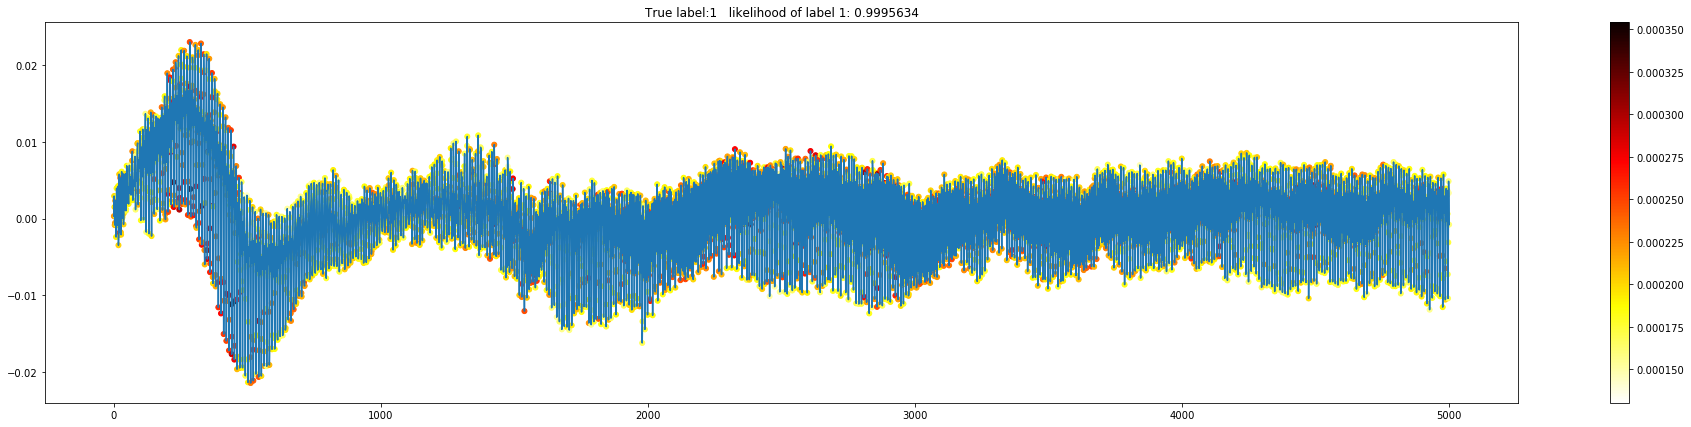

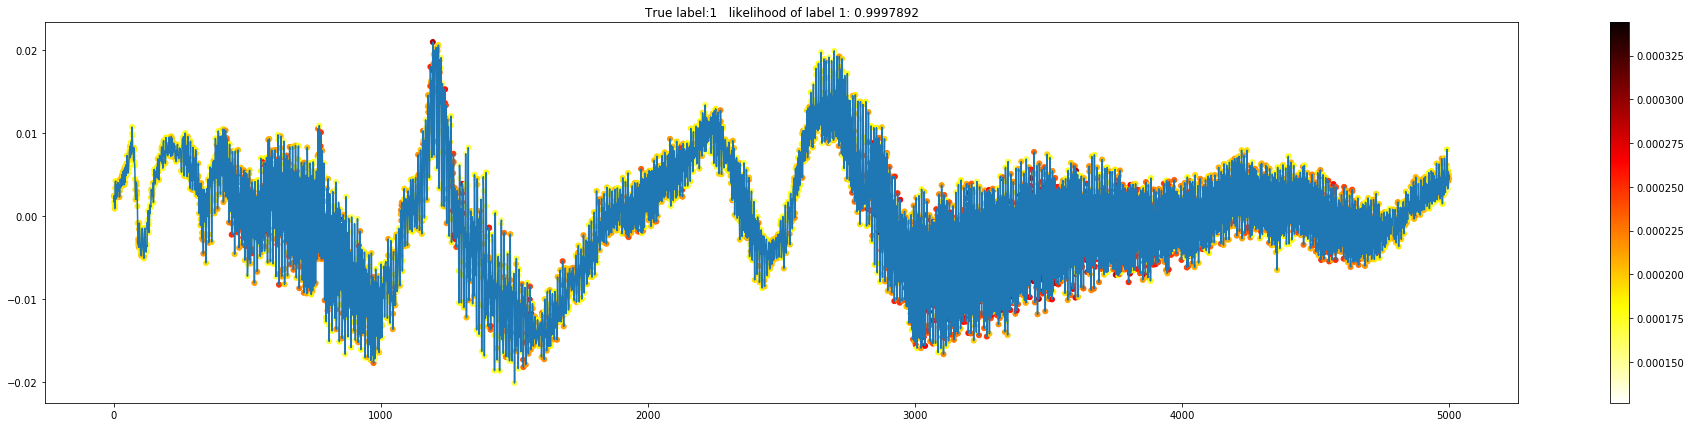

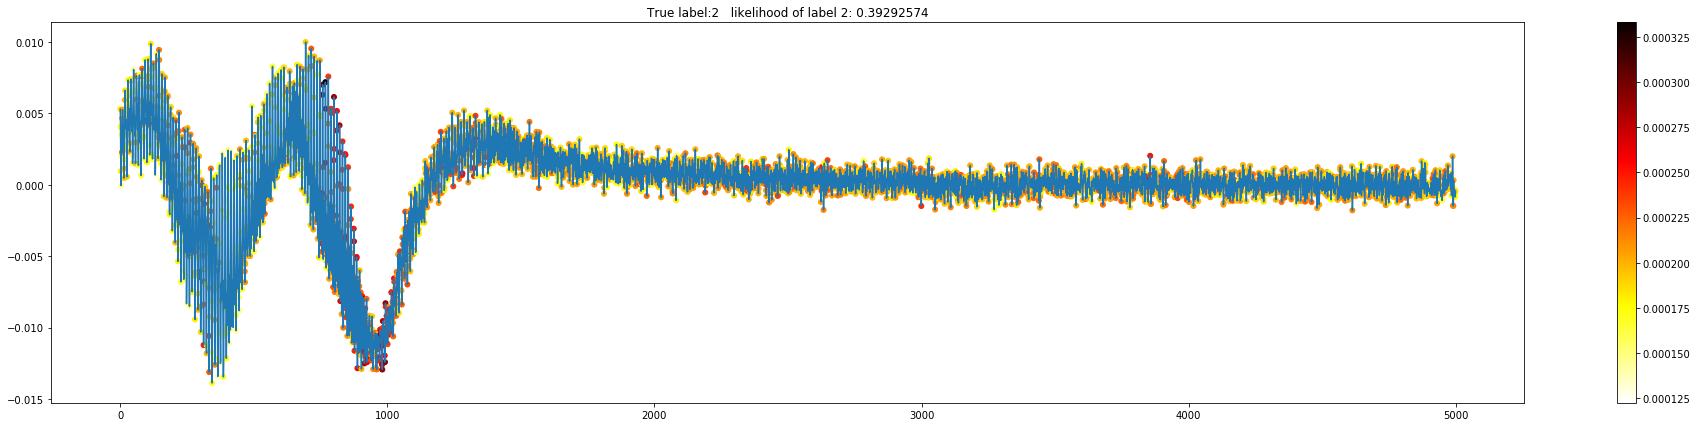

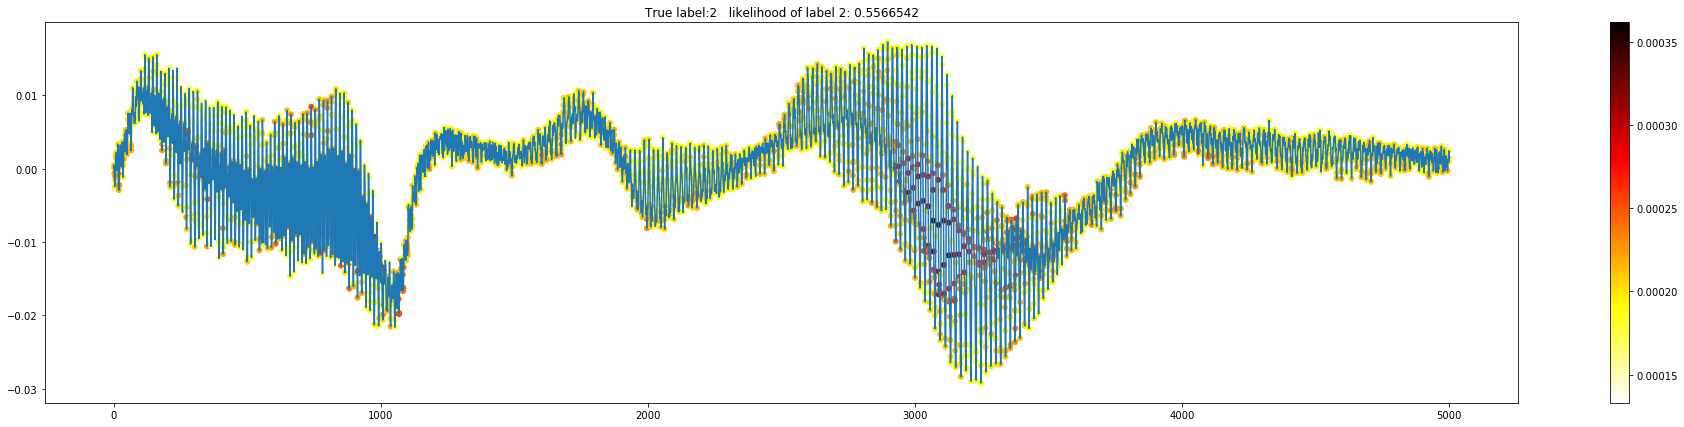

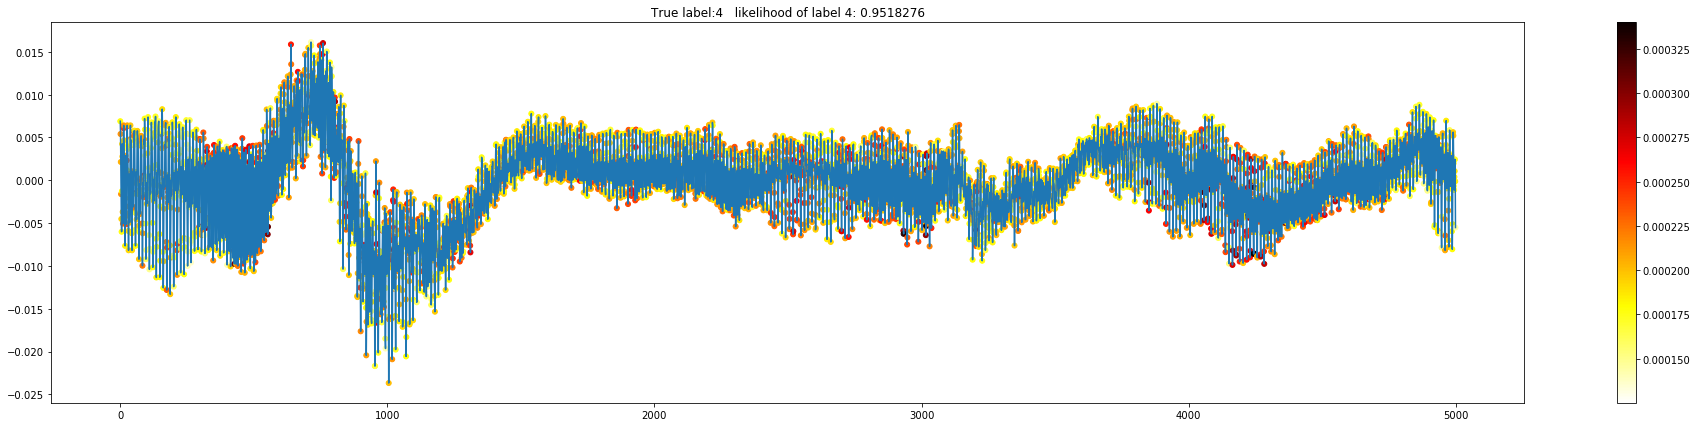

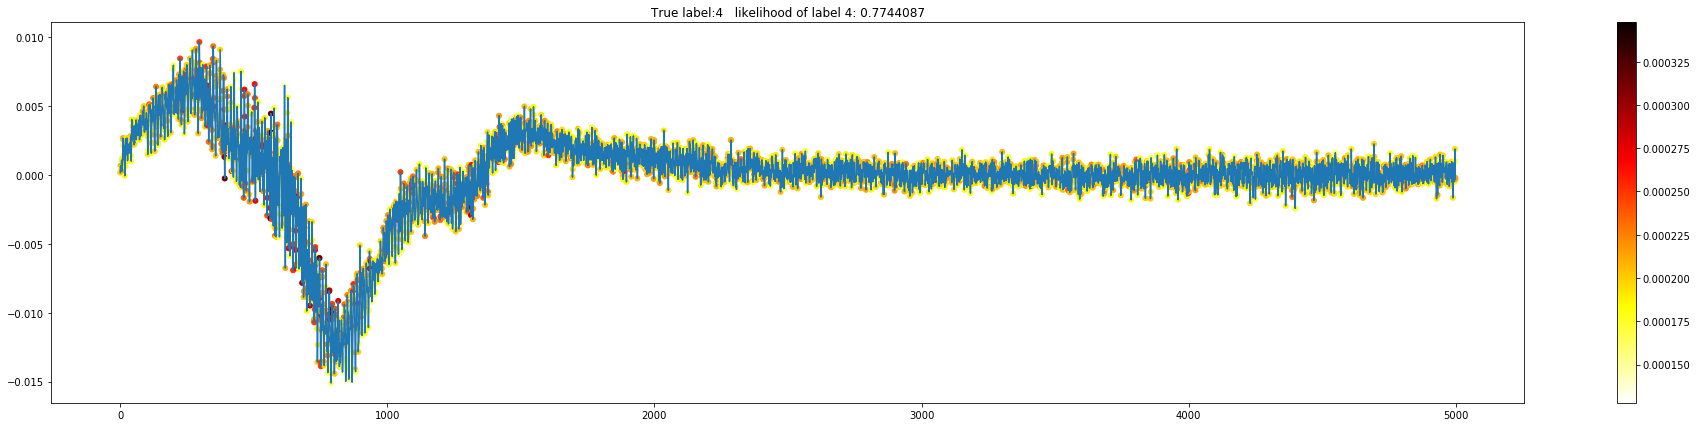

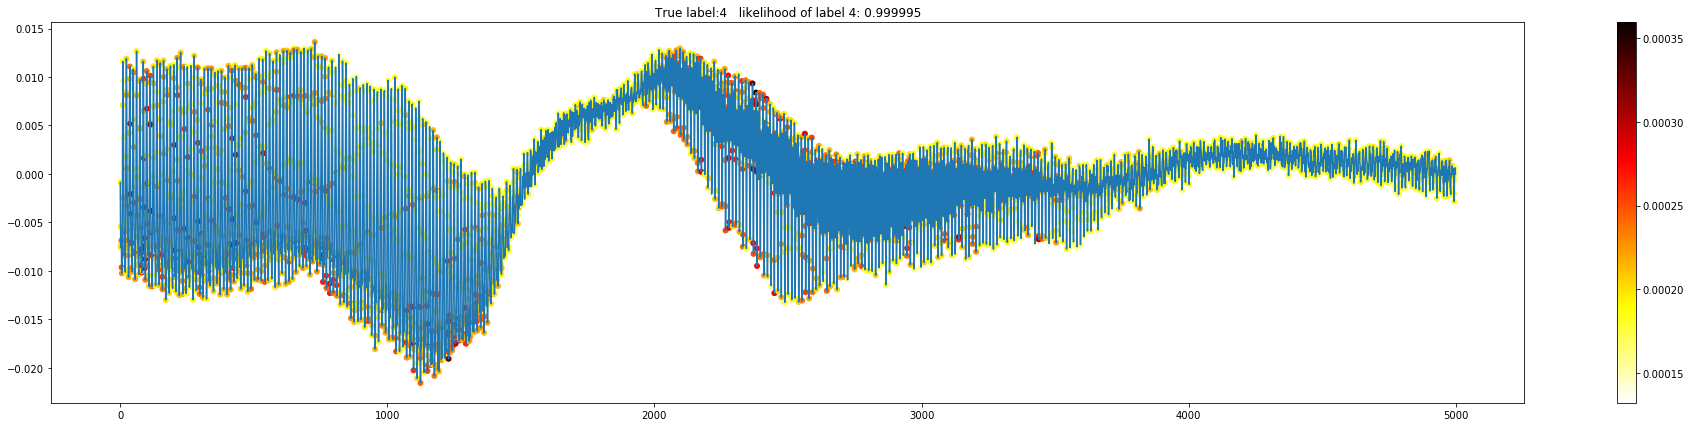

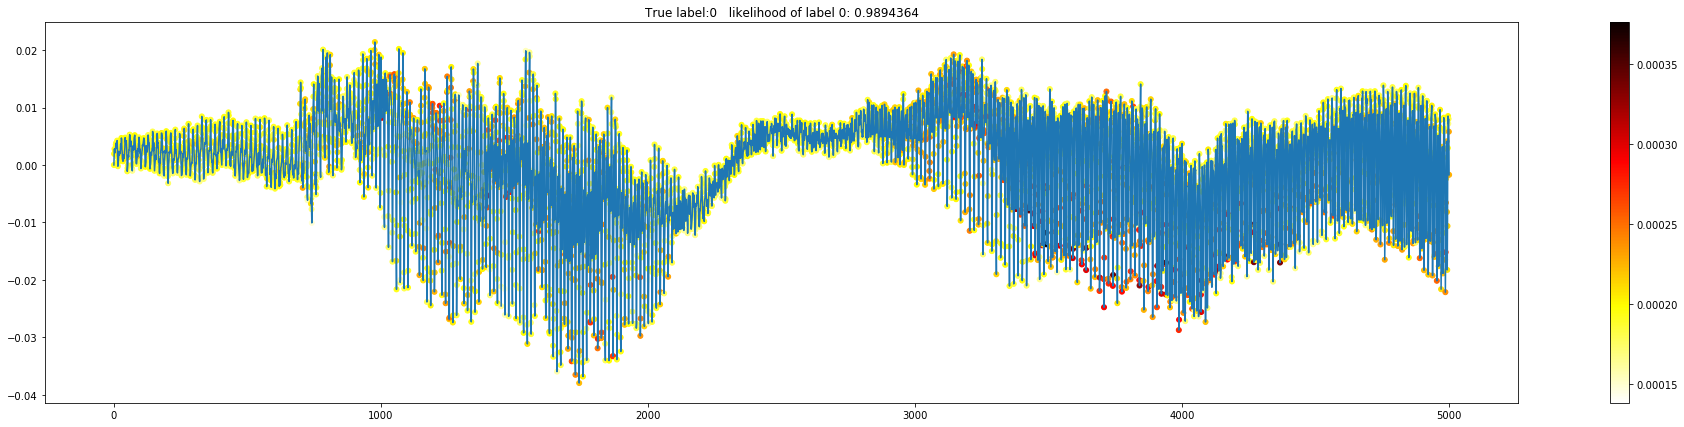

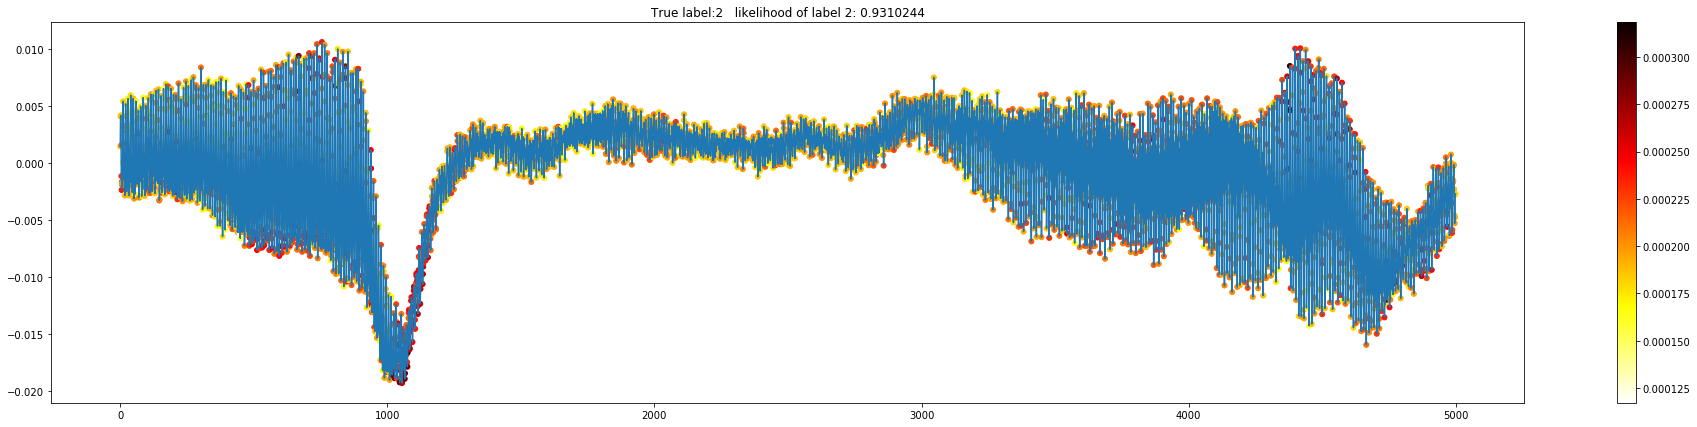

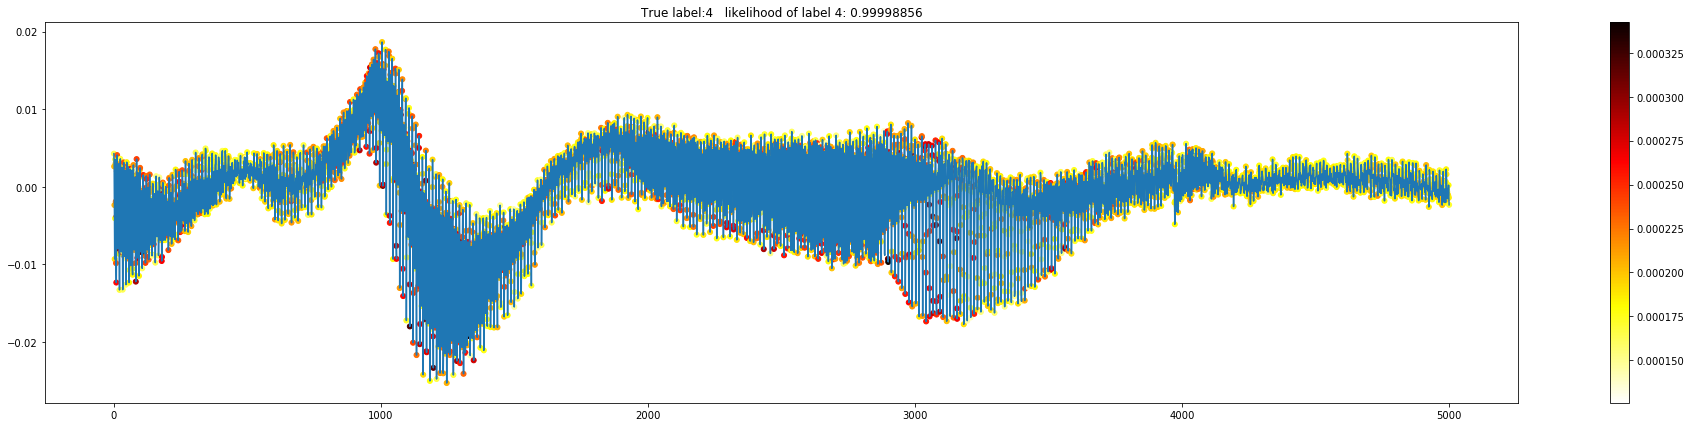

In [23]:
CAM = np.dot(last_conv, softmax_weight)
for k in range(10):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(33, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r',c=c[k, :, :, int(y_test[k])].squeeze(), s=25);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();

# c=c[k, :, :, int(y_test[k])].squeeze(),

In [95]:
CAM.shape

(50, 5000, 1, 6)

In [51]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5])